<a href="https://colab.research.google.com/github/ydeng-MLM/MLM_Lab_Miscellaneous/blob/main/lmfit_Lorentz_to_TCMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!pip install lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 12.8 MB/s eta 0:00:00


In [3]:
from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit

In [4]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libharfbuzz-icu0 libidn11
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpdfbox-java
  libptexenc1 libruby2.7 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data preview-latex-style
  rake ruby ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit
  ruby-xmlrpc ruby2.7 rubygems-integration t1utils tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fon

In [5]:
!pip install SciencePlots
import scienceplots
plt.style.use(['science', 'nature'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Lorentz/TCMT definition

In [6]:
def slab_transfer_model(f_min, f_max, eps_inf, wp, w0, g, mu_inf, wp_m, w0_m, g_m, d):
  #Define some universal constants
  c=3e8
  e0=(1e7)/(4*np.pi*c**2);
  m0=4*np.pi*10**(-7);
  z0=np.sqrt(m0/e0);

  #Specify the frequency range in hertz and radians, the free space
  #wavevector and wavelength
  N = int(f_max/1e12*100)
  f=np.linspace(f_min,f_max,N);
  w=2*np.pi*f;
  k0=w/c;
  lambda0=2*np.pi/k0;

  #Define the Lorentz oscillator in epsilon and n, define incident angle and
  #thickness
  er=eps_inf+(wp**2/(w0**2-w**2-1j*g*w)) #Lorentz oscillator
  mr=mu_inf+(wp_m**2/(w0_m**2-w**2-1j*g_m*w)) #Lorentz oscillator
  eps=e0*er #permittivity
  mu=m0*mr #permeability
  mu1=np.real(mu)
  mu2=np.imag(mu)
  n=np.sqrt(er)*np.sqrt(mr) #complex index of refraction
  n1=np.real(n) #real index
  n2=np.imag(n) #imaginary index

  #Some other optical constants
  z=np.sqrt(mu/eps) #impedance
  k=w*n/c #wavevector

  #Impedence method next
  M12=1j/2*(z0/z-z/z0)*np.sin(k*d);
  M22=np.cos(k*d)-1j/2*(z0/z+z/z0)*np.sin(k*d);
  r=-M12/M22;
  t=1/M22;

  R=np.abs(r)**2;
  T=np.abs(t)**2;

  return f, r, t, R, T

In [7]:
def TCMT_general(w,w01,w02,g0,g1,d1,b1,g2,d2,b2,r,t):
  beta = b1 + b2
  P1=-1j*(w-w01)+d1+g1*(1-np.exp(1j*beta))/(2)
  P2=-1j*(w-w02)+d2+g2*(1-np.exp(1j*beta))/(2);
  L1=-1j*(w-w01)+d1+g1;
  L2=-1j*(w-w02)+d2+g2;

  S11=r-((P2*g1+P1*g2)*r+(P2*g1*np.exp(1j*b1)+P1*g2*np.exp(1j*b2))*t)/(L1*L2-g0**2)
  S21=t-((P2*g1*np.exp(1j*b1)+P1*g2*np.exp(1j*b2))*r+(P2*g1+P1*g2)*t)/(L1*L2-g0**2)
  S12=t-((P2*g1+P1*g2)*t+(P2*g1*np.exp(1j*b1)+P1*g2*np.exp(1j*b2))*r)/(L1*L2-g0**2)
  S22=r-((P2*g1*np.exp(1j*b1)+P1*g2*np.exp(1j*b2))*t+(P2*g1+P1*g2)*r)/(L1*L2-g0**2)

  return S11, S21

In [8]:
def TCMT_dengen(w,w01,w02,g1,d1,g2,d2):
  c1 = g1/(-1j*(w-w01)+g1+d1)
  c2 = g2/(-1j*(w-w02)+g2+d2)
  r_nr = 0
  t_nr = 1
  r = (1 - c1 - c2)*r_nr+(-c1+c2)*t_nr
  t = (1 - c1 - c2)*t_nr+(-c1+c2)*r_nr
  
  return r,t

#Fitting function define

In [236]:
def random_lorentz_gen(fp=1e12, simple=False):
  if simple:
    eps_inf=1
    wp=2*np.pi*fp
    w0=2*np.pi*2e12
    g=2*np.pi*0.05e12

    mu_inf=1
    wp_m=wp
    w0_m=w0
    g_m=g

    d = 5e-6
  else:
    eps_inf=np.random.uniform(0, 1, 1)
    wp=2*np.pi*np.random.uniform(1e12, 2e12, 1)
    w0=2*np.pi*np.random.uniform(1e12, 4e12, 1)
    g=2*np.pi*np.random.uniform(0.05e12, 1e12, 1)

    mu_inf=np.random.uniform(0, 1, 1)
    wp_m=2*np.pi*np.random.uniform(1e12, 2e12, 1)
    w0_m=2*np.pi*np.random.uniform(1e12, 4e12, 1)
    g_m=2*np.pi*np.random.uniform(0.05e12, 1e12, 1)

    d = np.random.uniform(1e-6, 10e-6, 1)

  f, r, t, R, T = slab_transfer_model(0, 5e12, eps_inf, wp, w0, g, mu_inf, wp_m, w0_m, g_m, d)

  rt_lorentz = np.concatenate((np.real(r), np.imag(r), np.real(t), np.imag(t)))

  return np.array([eps_inf, wp, w0, g, mu_inf, wp_m, w0_m, g_m, d]), rt_lorentz, f

In [237]:
def random_TCMT_gen(simple=False):
  if simple:
    w01=2*np.pi*1e12
    d1=2*np.pi*1e9
    g1=2*np.pi*1e9
    b1=np.pi

    w02=2*np.pi*3e12
    d2=2*np.pi*1e9
    g2=2*np.pi*1e9
    b2=0

    g0 = 0

    eps_inf = 1
    mu_inf = 1
    d = 5e-6
  else:
    w01=2*np.pi*np.random.uniform(1e12, 4e12)
    d1=2*np.pi*np.random.uniform(5e8, 5e10)
    g1=2*np.pi*np.random.uniform(5e8, 5e10)
    b1=np.pi

    w02=2*np.pi*np.random.uniform(1e12, 4e12)
    d2=2*np.pi*np.random.uniform(5e8, 5e10)
    g2=2*np.pi*np.random.uniform(5e8, 5e10)
    b2=0

    g0 = np.random.uniform(0, 1)

    eps_inf=np.random.uniform(0, 2)
    mu_inf=np.random.uniform(0, 2)
    d = np.random.uniform(1e-6, 5e-6)

  f = np.linspace(0, 5e12, 500)
  w = 2*np.pi*f

  r_nr, t_nr = compute_nr(w,eps_inf, mu_inf,d)
  r,t = TCMT_general(w,w01,w02,g0,g1,d1,b1,g2,d2,b2,r_nr,t_nr)

  rt_TCMT = np.concatenate((np.real(r), np.imag(r), np.real(t), np.imag(t)))

  return np.array([w01, g1, d1, eps_inf, w02, g2, d2, mu_inf, d]), rt_TCMT, f, eps_inf, mu_inf, d

In [238]:
'''
def compute_nr(w, eps_inf, mu_inf, d):
  c=3e8
  e0=(1e7)/(4*np.pi*c**2)
  m0=4*np.pi*10**(-7)
  z0=np.sqrt(m0/e0)

  z = z0*np.sqrt(mu_inf)/np.sqrt(eps_inf)
  n = np.sqrt(mu_inf)*np.sqrt(eps_inf)
  k = w*n/c

  M12=1j/2*(z0/z-z/z0)*np.sin(k*d)
  M22=np.cos(k*d)-1j/2*(z0/z+z/z0)*np.sin(k*d)

  r_nr=-M12/M22
  t_nr=1/M22

  print(r_nr, t_nr)

  return r_nr, t_nr
'''

def compute_nr(w, eps_inf, mu_inf, d):
  c=3e8
  e0=(1e7)/(4*np.pi*c**2)
  m0=4*np.pi*10**(-7)
  z0=np.sqrt(m0/e0)

  z = z0*np.sqrt(mu_inf)/np.sqrt(eps_inf)
  n = np.sqrt(mu_inf)*np.sqrt(eps_inf)
  k = w*n/c

  r_nr = 0
  t_nr = np.exp(1j*k*d)
  return r_nr, t_nr

def TCMT_fit(w01,w02,g1,d1,g2,d2,b1,b2,g0,w,eps_inf,mu_inf,d):
  r_nr, t_nr = compute_nr(w,eps_inf, mu_inf,d)
  r,t = TCMT_general(w,w01,w02,g0,g1,d1,b1,g2,d2,b2,r_nr,t_nr)

  ans = np.concatenate((np.real(r), np.imag(r), np.real(t), np.imag(t)))
  return ans

In [239]:
def Lorentz_fit(w, eps_inf, wp, w0, g, mu_inf, wp_m, w0_m, g_m, d):
  f_max = np.max(w)/(2*np.pi)
  f_min = np.min(w)/(2*np.pi)
  f, r, t, R, T = slab_transfer_model(f_min, f_max, eps_inf, wp, w0, g, mu_inf, wp_m, w0_m, g_m, d)
  ans = np.concatenate((np.real(r), np.imag(r), np.real(t), np.imag(t)))
  return ans

In [240]:
def residual_LT(params, w, eps_inf, mu_inf, d, rt_Lorentz=None):
  w01 = params['w01']
  w02 = params['w02']
  g1 = params['g1']
  g2 = params['g2']
  d1 = params['d1']
  d2 = params['d2']
  b1 = params['b1']
  b2 = params['b2']
  g0 = params['g0']

  rt_TCMT = TCMT_fit(w01,w02,g1,d1,g2,d2,b1,b2,g0,w,eps_inf,mu_inf,d)

  if rt_Lorentz is None:
    return rt_TCMT

  loss = (rt_TCMT-rt_Lorentz)
  return loss

In [241]:
def residual_TL(params, w, rt_TCMT=None):
  eps_inf = params['eps_inf']
  wp = params['wp']
  w0 = params['w0']
  g = params['g']
  mu_inf = params['mu_inf']
  wp_m= params['wp_m']
  w0_m = params['w0_m']
  g_m = params['g_m']
  d = params['d']

  rt_Lorentz = Lorentz_fit(w, eps_inf, wp, w0, g, mu_inf, wp_m, w0_m, g_m, d)


  if rt_TCMT is None:
    return rt_Lorentz

  loss = (rt_Lorentz-rt_TCMT)
  return loss

#lmfit modual for NLSF - TCMT to Lorentz

In [242]:
N_test = 1
N_init = 1
Lorentz_params = []
TCMT_params = []
N_drop = 0

for i in range(N_test):
  TCMT_param, rt_TCMT, f, eps_inf, mu_inf, d = random_TCMT_gen(simple=False)

  best_mse = 1000
  out_best = None

  try:
    for j in range(N_init):
      params = Parameters()
      params.add('w0', value=np.random.uniform(TCMT_param[0],TCMT_param[0]), min=0.99*TCMT_param[0], max=1.01*TCMT_param[0])
      params.add('wp', value=np.random.uniform(5e11,2e12), min=1e9, max=100e12)
      params.add('g', value=np.random.uniform(0.05e12,1e12), min=1e9, max=1e12)
      params.add('eps_inf', value=eps_inf, min=0.99*eps_inf, max=1.01*eps_inf)
      params.add('w0_m', value=np.random.uniform(TCMT_param[4],TCMT_param[4]), min=0.99*TCMT_param[4], max=1.01*TCMT_param[4])
      params.add('wp_m', value=np.random.uniform(5e11,2e12), min=1e9, max=100e12)
      params.add('g_m', value=np.random.uniform(0.05e12,1e12), min=1e9, max=1e12)
      params.add('mu_inf', value=mu_inf, min=0.99*mu_inf, max=1.01*mu_inf)
      params.add('d', value=d, min=0.99*d, max=1.01*d)


      w = 2*np.pi*f

      out = minimize(residual_TL, params, args=(w, rt_TCMT), method='leastsq')
      fit = residual_TL(out.params, w)
      mse = np.mean((fit-rt_TCMT)**2)
      if mse < best_mse:
        best_mse = mse
        out_best = out

  except:
      print('Large value/NaN values from Transfer matrix! Skipping current fit.')
      continue

  
  Lorentz_params.append(np.array(out_best.params))
  TCMT_params.append(TCMT_param)


Lorentz_params = np.array(Lorentz_params)
TCMT_params = np.array(TCMT_params)

In [233]:
print(TCMT_param)
print(np.array(out_best.params))

[1.99962345e+13 1.97506136e+11 1.55347270e+11 1.60077555e+00
 6.31757398e+12 1.82770783e+11 2.39673924e+11 2.57920846e-01
 3.33542170e-06]
[2.00225241e+13 9.49551828e+12 3.88014143e+11 1.58476780e+00
 6.29843582e+12 7.38803822e+12 4.03514035e+11 2.60499976e-01
 3.30206748e-06]


In [234]:
fit = residual_TL(out_best.params, w)

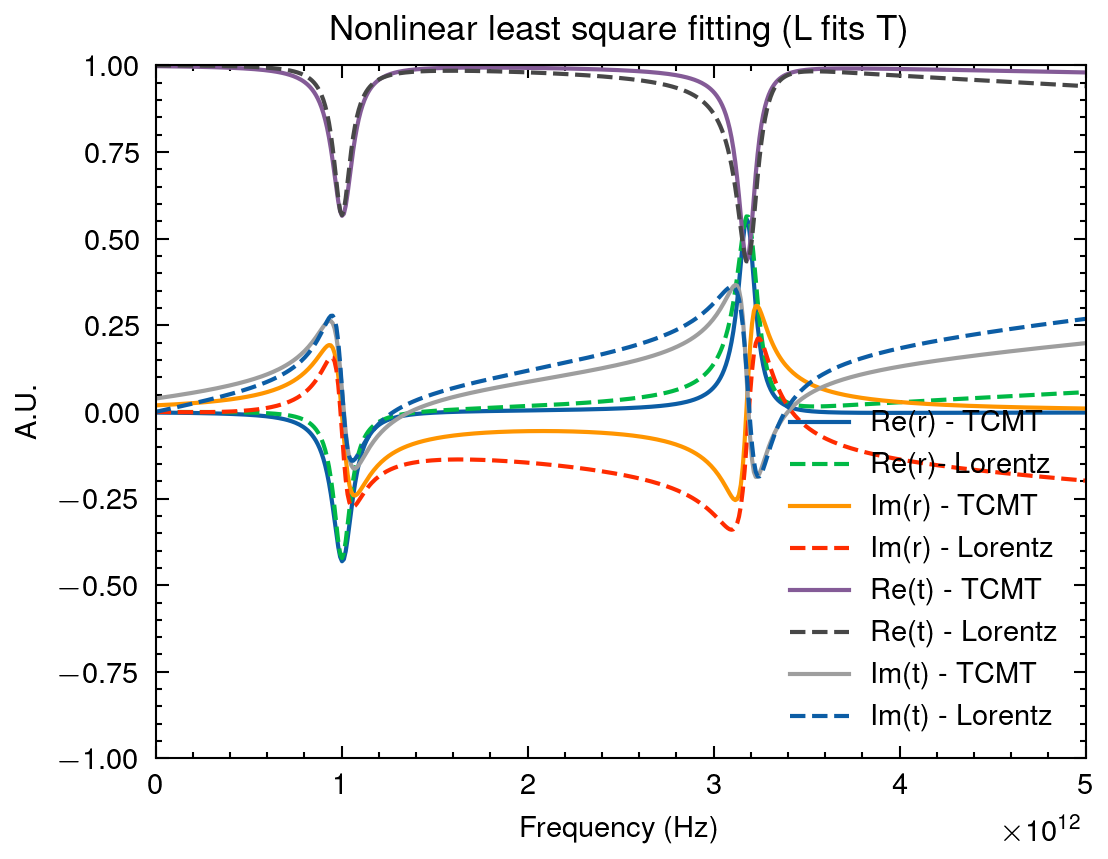

In [235]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(f, rt_TCMT[:500], label='Re(r) - TCMT')
plt.plot(f, fit[:500], '--', label='Re(r)- Lorentz')
plt.plot(f, rt_TCMT[500:1000], label='Im(r) - TCMT')
plt.plot(f, fit[500:1000], '--', label='Im(r) - Lorentz')
plt.plot(f, rt_TCMT[1000:1500], label='Re(t) - TCMT')
plt.plot(f, fit[1000:1500], '--', label='Re(t) - Lorentz')
plt.plot(f, rt_TCMT[1500:], label='Im(t) - TCMT')
plt.plot(f, fit[1500:], '--', label='Im(t) - Lorentz')


plt.xlabel('Frequency (Hz)')
plt.ylabel('A.U.')
plt.title('Nonlinear least square fitting (L fits T)')
plt.xlim([np.min(f), np.max(f)])
plt.ylim([-1, 1])
plt.legend(loc="lower right")

In [210]:
Lorentz_params = Lorentz_params.squeeze()
TCMT_params = TCMT_params.squeeze()

print(TCMT_params.shape, Lorentz_params.shape)

(9,) (9,)


In [211]:
np.save('T_0511_epsmu2_data', TCMT_params)
np.save('L_0511_epsmu2_data', Lorentz_params)

In [212]:
T_train = np.load('T_0509_epsmu2_data.npy')
L_train = np.load('L_0509_epsmu2_data.npy')

T_new = np.load('T_0511_epsmu2_data.npy')
L_new = np.load('L_0511_epsmu2_data.npy')

FileNotFoundError: ignored

In [ ]:
T_append = np.vstack((T_train, T_new))
L_append = np.vstack((L_train, L_new))

print(T_train.shape, T_new.shape, T_append.shape)
print(L_train.shape, L_new.shape, L_append.shape)

In [ ]:
mse_arr = []

for i in range(T_append.shape[0]):
  f = np.linspace(0,5e12,500)
  w = 2*np.pi*f
  T_ans = TCMT_fit(T_append[i,0],T_append[i,4],T_append[i,1],T_append[i,2],T_append[i,5],T_append[i,6],np.pi,0,0,w,T_append[i,3],T_append[i,7],T_append[i,8])
  L_ans = Lorentz_fit(w, L_append[i,3], L_append[i,1], L_append[i,0], L_append[i,2], L_append[i,7], L_append[i,5], L_append[i,4], L_append[i,6], L_append[i,8])
  mse = np.mean((T_ans-L_ans)**2)
  mse_arr.append(mse)

In [ ]:
mse_arr = np.array(mse_arr).reshape(-1,1)
print(mse_arr.shape)

In [ ]:
L_append = np.hstack((L_append, mse_arr))

In [ ]:
print(L_append.shape)

In [ ]:
np.save('T_0511_data', T_append)
np.save('L_0511_data', L_append)

#lmfit modual for NLSF - Lorentz to TCMT

In [253]:
N_test = 1
N_init = 1
Lorentz_params = []
TCMT_params = []
N_drop = 0

for i in range(N_test):
  Lorentz_param, rt_Lorentz, f = random_lorentz_gen(fp=2e12, simple=True)

  best_mse = 1000
  out_best = None

  for j in range(N_init):
    params = Parameters()
    params.add('w01', value=np.random.uniform(Lorentz_param[2],Lorentz_param[2]), min=0.5*Lorentz_param[2], max=1.5*Lorentz_param[2])
    params.add('w02', value=np.random.uniform(Lorentz_param[6],Lorentz_param[6]), min=0.5*Lorentz_param[6], max=1.5*Lorentz_param[6])
    params.add('d1', value=np.random.uniform(1e10,1e12), min=0, max=1e14)
    params.add('d2', value=np.random.uniform(1e10,1e12), min=0, max=1e14)
    params.add('g1', value=np.random.uniform(1e10,1e12), min=0, max=1e14)
    params.add('g2', value=np.random.uniform(1e10,1e12), min=0, max=1e14)
    params.add('b1', value=np.random.uniform(0,2*np.pi), min=0, max=2*np.pi)
    params.add('b2', value=np.random.uniform(0,2*np.pi), min=0, max=2*np.pi)
    params.add('g0', value=np.random.uniform(0,1), min=0, max=100)

    w = 2*np.pi*f
    eps_inf = Lorentz_param[0]
    mu_inf = Lorentz_param[4]
    d = Lorentz_param[8]

    out = minimize(residual_LT, params, args=(w, eps_inf, mu_inf, d, rt_Lorentz), method='leastsq')
    fit = residual_LT(out.params, w, eps_inf, mu_inf, d)
    mse = np.mean((fit-rt_Lorentz)**2)
    if mse < best_mse:
      best_mse = mse
      out_best = out

  if best_mse < 1e-3:
    Lorentz_params.append(Lorentz_param)
    TCMT_params.append(np.array(out_best.params))


Lorentz_params = np.array(Lorentz_params)
TCMT_params = np.array(TCMT_params)

In [254]:
print(params)
print(out_best.params)

Parameters([('w01', <Parameter 'w01', value=12566370614359.172, bounds=[6283185307179.586:18849555921538.758]>), ('w02', <Parameter 'w02', value=12566370614359.172, bounds=[6283185307179.586:18849555921538.758]>), ('d1', <Parameter 'd1', value=548606943285.93304, bounds=[0:100000000000000.0]>), ('d2', <Parameter 'd2', value=108132295819.98547, bounds=[0:100000000000000.0]>), ('g1', <Parameter 'g1', value=641070932514.0574, bounds=[0:100000000000000.0]>), ('g2', <Parameter 'g2', value=282603443186.84393, bounds=[0:100000000000000.0]>), ('b1', <Parameter 'b1', value=5.823170100697675, bounds=[0:6.283185307179586]>), ('b2', <Parameter 'b2', value=6.126164092442749, bounds=[0:6.283185307179586]>), ('g0', <Parameter 'g0', value=0.9509525295652118, bounds=[0:100]>)])
Parameters([('w01', <Parameter 'w01', value=12629405290111.738, bounds=[6283185307179.586:18849555921538.758]>), ('w02', <Parameter 'w02', value=12629418611987.605, bounds=[6283185307179.586:18849555921538.758]>), ('d1', <Parame

In [255]:
fit = residual_LT(out_best.params, w, eps_inf, mu_inf, d)

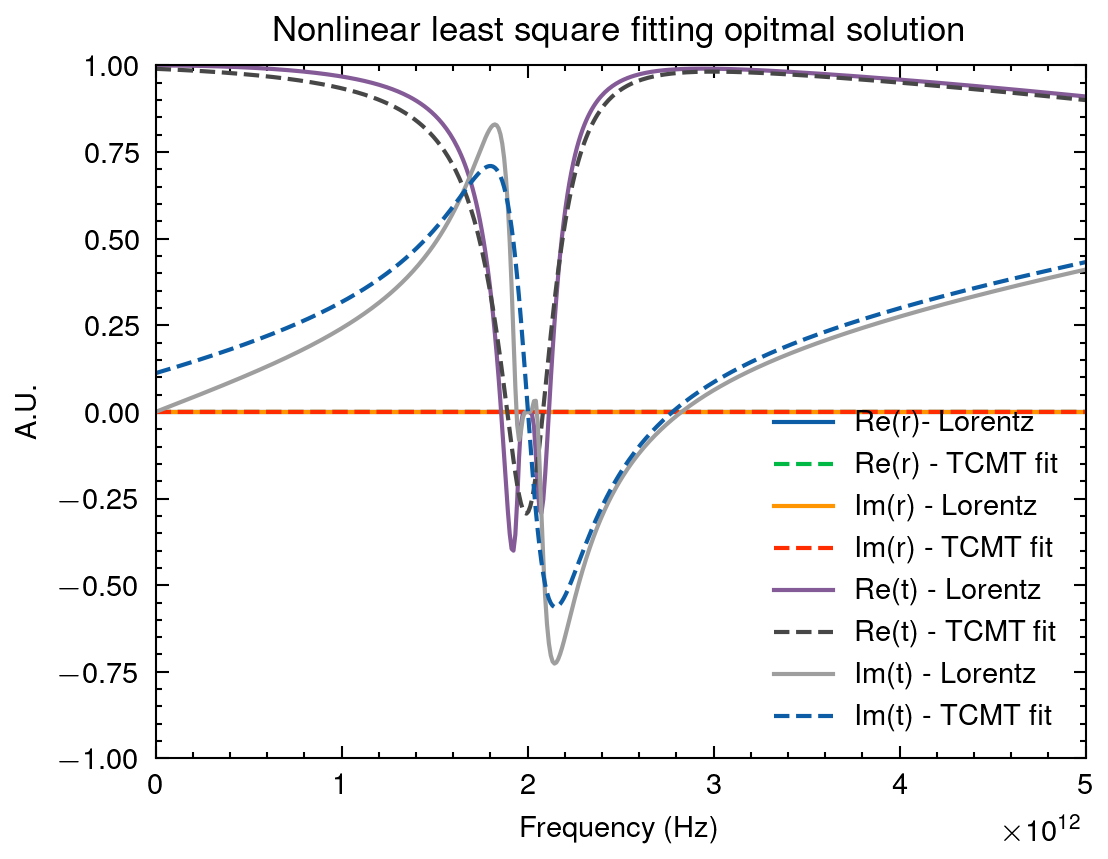

In [256]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(f, rt_Lorentz[:500], label='Re(r)- Lorentz')
plt.plot(f, fit[:500], '--', label='Re(r) - TCMT fit')
plt.plot(f, rt_Lorentz[500:1000], label='Im(r) - Lorentz')
plt.plot(f, fit[500:1000], '--', label='Im(r) - TCMT fit')
plt.plot(f, rt_Lorentz[1000:1500], label='Re(t) - Lorentz')
plt.plot(f, fit[1000:1500], '--', label='Re(t) - TCMT fit')
plt.plot(f, rt_Lorentz[1500:], label='Im(t) - Lorentz')
plt.plot(f, fit[1500:], '--', label='Im(t) - TCMT fit')


plt.xlabel('Frequency (Hz)')
plt.ylabel('A.U.')
plt.title('Nonlinear least square fitting opitmal solution')
plt.xlim([np.min(f), np.max(f)])
plt.ylim([-1, 1])
plt.legend(loc="lower right")

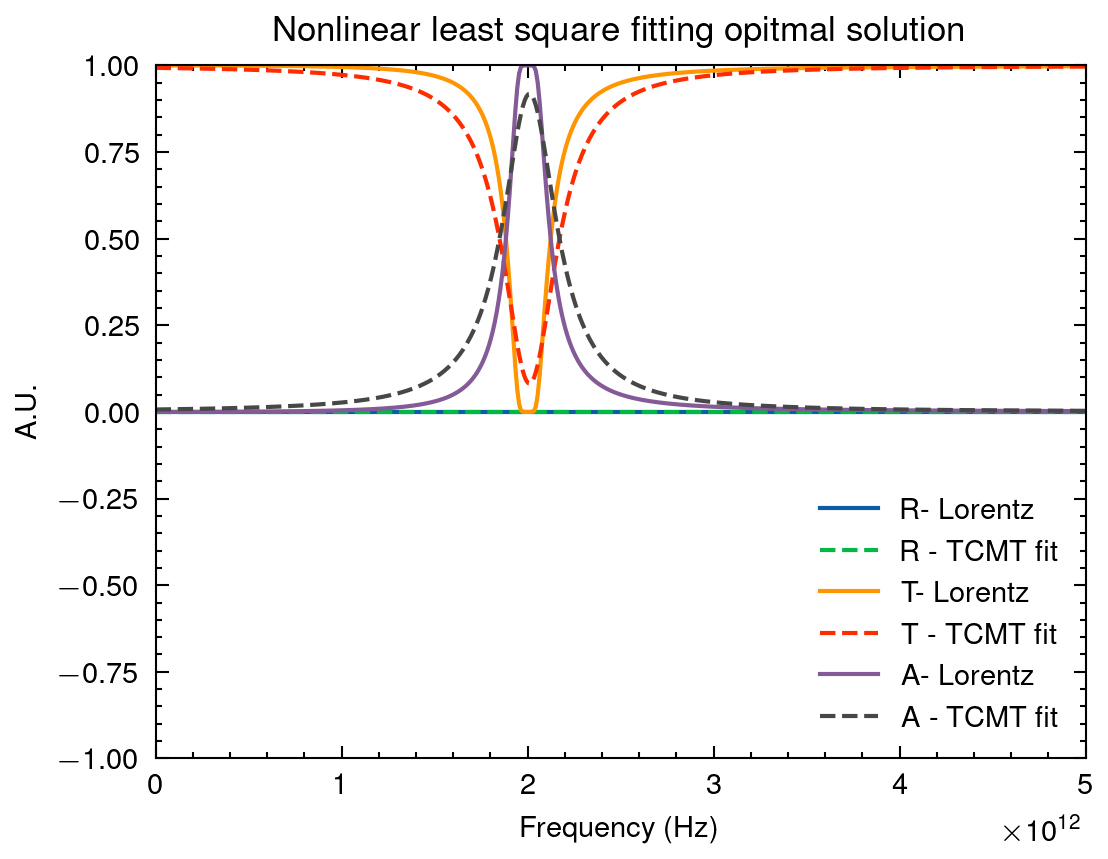

In [257]:
Rl = np.abs(rt_Lorentz[:500]+1j*rt_Lorentz[500:1000])**2
Rt = np.abs(fit[:500]+1j*fit[500:1000])**2
Tl = np.abs(rt_Lorentz[1000:1500]+1j*rt_Lorentz[1500:])**2
Tt = np.abs(fit[1000:1500]+1j*fit[1500:])**2


Al = 1-Rl-Tl
At = 1-Rt-Tt

plt.figure(figsize=(4,3), dpi=300)
plt.plot(f, Rl, label='R- Lorentz')
plt.plot(f, Rt, '--', label='R - TCMT fit')
plt.plot(f, Tl, label='T- Lorentz')
plt.plot(f, Tt, '--', label='T - TCMT fit')
plt.plot(f, Al, label='A- Lorentz')
plt.plot(f, At, '--', label='A - TCMT fit')


plt.xlabel('Frequency (Hz)')
plt.ylabel('A.U.')
plt.title('Nonlinear least square fitting opitmal solution')
plt.xlim([np.min(f), np.max(f)])
plt.ylim([-1, 1])
plt.legend(loc="lower right")

In [ ]:
Lorentz_params = Lorentz_params.squeeze()
TCMT_params = TCMT_params.squeeze()

print(TCMT_params.shape, Lorentz_params.shape)

(9787, 9) (9787, 9)


In [ ]:
np.save('T_data', TCMT_params)
np.save('L_data', Lorentz_params)

# Test plot of T with transfer matrix and z=1

In [243]:
wp = 2*np.pi*5e12
w0 = 2*np.pi*2e12
g = 2*np.pi*0.05e12

wp_m = wp
w0_m = w0
g_m = g

d = 5e-6

er=1+(wp**2/(w0**2-w**2-1j*g*w)) #Lorentz oscillator
mr=1+(wp_m**2/(w0_m**2-w**2-1j*g_m*w)) #Lorentz oscillator

n = np.sqrt(er)*np.sqrt(mr)
c=3e8
k = w/c

In [244]:
t = np.exp(1j*n*k*d)
T = np.abs(t)**2
A = 1-T

In [251]:
g1 = 1e12

tt = (1-(2*g1)/(-1j*(w-w0)+2*g1))*np.exp(1j*k*d)
Tt = np.abs(tt)**2

(0.0, 1.0)

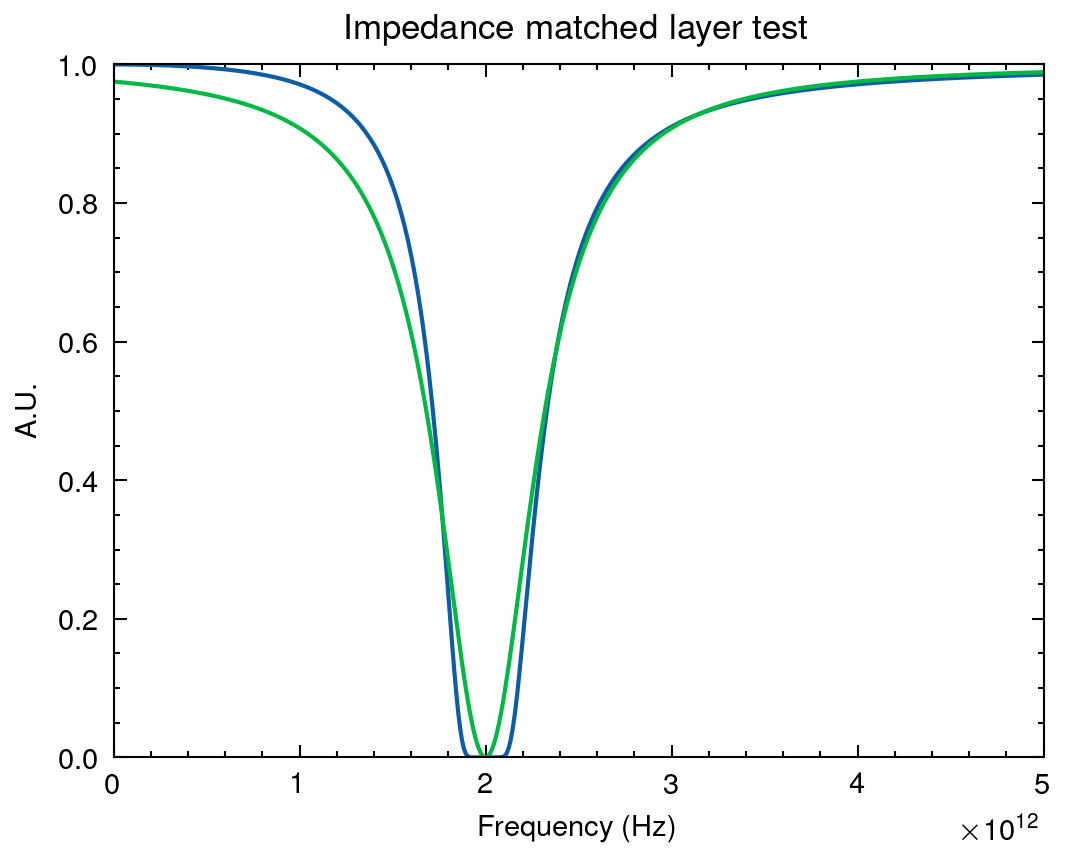

In [252]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(f,T)
plt.plot(f,Tt)
plt.xlabel('Frequency (Hz)')
plt.ylabel('A.U.')
plt.title('Impedance matched layer test')
plt.xlim([np.min(f), np.max(f)])
plt.ylim([0, 1])